In [3]:
# %load erm_vs_pf_final.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron as Mymodel1
from sklearn.linear_model import LogisticRegression as Mymodel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import minmax_scale

import time

import preprocess as ap


In [4]:
#preprocess train and test data to get data without sensitive labels
train_data, train_label, test_data, test_label = ap.compas_preprocess('compas-scores-two-years.csv', True)

total_size = len(train_label)
total_size_test = len(test_label)

train_data_no_sensitive = train_data.drop(columns = ['race', 'sex'])
test_data_no_sensitive = test_data.drop(columns = ['race', 'sex'])

#transform data into one hot vectors
train_data_1hot = ap.get_1hot(train_data_no_sensitive)
test_data_1hot = ap.get_1hot(test_data_no_sensitive)

# Fitting scaler (not really necessary)
scaler = StandardScaler()
scaler.fit(train_data_1hot)  
train_data_scaled = scaler.transform(train_data_1hot)
test_data_scaled = scaler.transform(test_data_1hot)


Index(['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
       'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',
       'two_year_recid', 'c_jail_in', 'c_jail_out'],
      dtype='object')


In [5]:
#implementing GREEDY
print('Implementing Greedy...')
remaining_data = train_data_scaled
hack_data = remaining_data[0:2] #see hack_label below

remaining_label = train_label
hack_label = remaining_label[0:2] #SGD blackbox trainer always needs labels of >=2 classes
length_rem = len(remaining_label)
#lists to collect greedy classifiers and corresponding weights
classifiers = []
weights = np.array([])
count = 1

#train greedy step by step
while length_rem > 0:
    classifiers.append(Mymodel(random_state = 0, solver = 'newton-cg'))
    clf = classifiers[-1]
    data_size = len(remaining_label)

    if len(np.unique(remaining_label)) > 1:
        clf.fit(remaining_data, remaining_label)
        predicted = clf.predict(remaining_data)
        remaining_indices = np.not_equal(predicted, remaining_label)
        if count == 1:
            agree_indices = np.equal(predicted, remaining_label)
            agree_data = remaining_data[agree_indices]
            agree_label = remaining_label[agree_indices]
        remaining_data = remaining_data[remaining_indices]
        remaining_label = remaining_label[remaining_indices]
        length_rem = len(remaining_label)
    else:
        remaining_data = np.append(remaining_data, hack_data, axis = 0)
        remaining_label = remaining_label.append(hack_label)
        clf.fit(remaining_data, remaining_label)
        length_rem = 0
        
    current_weight = data_size - length_rem
    weights = np.append(weights, current_weight)

    count = count + 1
print('Done.')

weights = weights/sum(weights)

greedy_overall_acc_train = ap.accuracy_randomized(classifiers, weights, train_data_scaled, train_label)
greedy_overall_acc_test = ap.accuracy_randomized(classifiers, weights, test_data_scaled, test_label)

Implementing Greedy...
Done.


In [6]:
#implementing seqPAV
#num_iter = total_size #better convergence for 2n?
num_iter = 500
print(('Implementing SeqPAV with num_iter = %d' %num_iter))
points_tally = np.ones(len(train_label))
#have a list of classifiers (per time step)
seqpav = []
seqpav_weights2 = []
count = 1
t1 = time.time()
while count <= num_iter: 
    if count % 100 == 0:
        print(('Iteration # %d' % count))
    sample_weights = minmax_scale(1 / points_tally, feature_range = (0.1, 10))
    #find current best classifier
    seqpav.append(Mymodel(random_state = 0, solver = 'newton-cg', max_iter = 2000))
    #seqpav.append(Mymodel1(random_state = 0))
    clf = seqpav[-1]
    clf.fit(train_data_scaled, train_label, sample_weight = sample_weights)
    #update weights
    prediction = clf.predict(train_data_scaled)
    #convert prediction vs labels to 0,1
    update = np.zeros(len(prediction))
    agreement = np.equal(prediction, train_label)
    update[agreement] = 1
    #update tally and move to next round
    w = sum(np.multiply((1/points_tally),update))
    seqpav_weights2.append(w)
    points_tally = points_tally + update
    count = count + 1

t2 = time.time()
print(('Done. Time taken = %.2f' %(t2-t1)))

#seqpav_weights = np.ones(len(seqpav)) / len(seqpav)
seqpav_weights = seqpav_weights2 / sum(seqpav_weights2)
seqpav_overall_acc_train = ap.accuracy_randomized(seqpav, seqpav_weights, train_data_scaled, train_label)
seqpav_overall_acc_test = ap.accuracy_randomized(seqpav, seqpav_weights, test_data_scaled, test_label)

Implementing SeqPAV with num_iter = 500
Iteration # 100
Iteration # 200
Iteration # 300
Iteration # 400
Iteration # 500
Done. Time taken = 10.81


----------Analysis------------
Total number of train data-points = 4937
Total number of test data-points = 1235
Overall train accuracy of ERM = 0.75775 
Overall test accuracy of ERM = 0.74899 
Overall train accuracy of Greedy = 0.63708 
Overall test accuracy of Greedy = 0.63346 
Support of greedy (number of classifiers) = 4
and their weights are:
[7.57747620e-01 2.32934981e-01 9.11484707e-03 2.02552157e-04]
Number of iteration for SeqPAV = 500
Overall train accuracy of SeqPAV = 0.62380 
Overall test accuracy of SeqPAV = 0.61770 
i = 4
j = 0
i = 5
j = 0
i = 6
j = 0
i = 7
j = 0
i = 8
j = 0
i = 9
j = 0
i = 10
j = 0


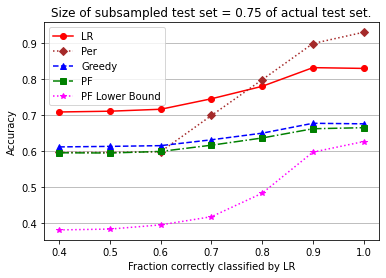

1.0
1.0
0.9933774834437086
1.0
0.9960159362549801
0.9700996677740864
0.9145299145299145
0.7930174563591023
0.7228381374722838
0.6207584830339321
0.573502722323049
0.5490848585690515
0.565284178187404
0.5805991440798859
0.5579227696404794
0.5780274656679151
0.6263219741480611
0.6503884572697003
0.6719242902208202
0.6903096903096904
0.70313986679353
0.7148047229791099
0.7324066029539531
0.742714404662781
0.7473684210526316


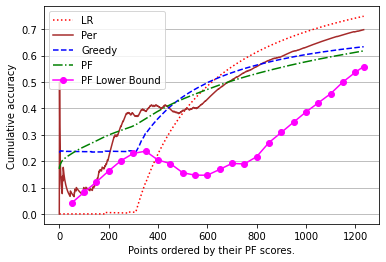

In [7]:
#Analysis
print('----------Analysis------------')
print(("Total number of train data-points = %d" % total_size))
print(("Total number of test data-points = %d" % total_size_test))
print(("Overall train accuracy of ERM = %.5f " % classifiers[0].score(train_data_scaled, train_label)))
print(("Overall test accuracy of ERM = %.5f " % classifiers[0].score(test_data_scaled, test_label)))
print(("Overall train accuracy of Greedy = %.5f " % greedy_overall_acc_train))
print(("Overall test accuracy of Greedy = %.5f " % greedy_overall_acc_test))
print(("Support of greedy (number of classifiers) = %d" % len(weights)))
print("and their weights are:")
print(weights)
print(("Number of iteration for SeqPAV = %d" % num_iter))
print(("Overall train accuracy of SeqPAV = %.5f " % seqpav_overall_acc_train))
print(("Overall test accuracy of SeqPAV = %.5f " % seqpav_overall_acc_test))

erm = classifiers[0]
per = Mymodel1(random_state = 0)
per.fit(train_data_scaled, train_label)
per_preds = per.predict(test_data_scaled)
erm_preds = erm.predict(test_data_scaled)
erm_preds = per_preds
agree_inds = np.equal(erm_preds, test_label)
correct_data = test_data_scaled[agree_inds]
correct_label = test_label[agree_inds].to_numpy()
correct_inds = list(range(len(correct_label)))
disagree_inds = np.not_equal(erm_preds, test_label)
wrong_data = test_data_scaled[disagree_inds]
wrong_label = test_label[disagree_inds].to_numpy()
wrong_inds = list(range(len(wrong_label)))

erm_accs = []
seqpav_accs = []
greedy_accs = []
opt_accs = []
per_accs = []
test_size = len(test_label)
correct_size = len(correct_label)
wrong_size = len(wrong_label)
l = int(0.75 * test_size)

for t in range(7):
    i = t + 4
    print(("i = %d" %i))
    samples_wrong_0 = l - int((i / 10) * l)
    samples_correct_0 = int((i / 10) * l)
    samples_correct, samples_wrong = ap.sample_sizes(l, correct_size, wrong_size, samples_correct_0, samples_wrong_0)
    erm_acc = 0
    seqpav_acc = 0
    greedy_acc = 0
    opt_acc = 0
    per_acc = 0
    for j in range(1):
        print(("j = %d" %j)) 
        inds = correct_inds.copy()
        np.random.shuffle(inds)
        correct_sample_inds = inds[0:samples_correct]
        correct_sample_data = correct_data[correct_sample_inds]
        correct_sample_label = correct_label[correct_sample_inds]
        inds = wrong_inds.copy()
        np.random.shuffle(inds)
        wrong_sample_inds = inds[0:samples_wrong]
        wrong_sample_data = wrong_data[wrong_sample_inds]
        wrong_sample_label = wrong_label[wrong_sample_inds]
        data = np.append(correct_sample_data, wrong_sample_data, axis = 0)
        label = np.append(correct_sample_label, wrong_sample_label, axis = 0)
        opt = Mymodel(random_state = 0, solver = 'newton-cg')
        opt.fit(data, label)
        opt_score = opt.score(data, label)
        opt_acc = opt_acc + (l / test_size) * opt_score * opt_score
        erm_acc = erm_acc + erm.score(data, label)
        per_acc = per_acc + per.score(data, label)
        seqpav_acc = seqpav_acc + ap.accuracy_randomized(seqpav, seqpav_weights, data, label)
        greedy_acc = greedy_acc + ap.accuracy_randomized(classifiers, weights, data, label)
    erm_acc = erm_acc / (j+1)
    seqpav_acc = seqpav_acc / (j+1)
    greedy_acc = greedy_acc / (j+1)
    opt_acc = opt_acc / (j+1)
    per_acc = per_acc / (j+1)
    erm_accs.append(erm_acc)
    seqpav_accs.append(seqpav_acc)
    greedy_accs.append(greedy_acc)
    opt_accs.append(opt_acc)
    per_accs.append(per_acc)
    
x = 0.1 * np.arange(4, 11, 1)
plt.plot(x, erm_accs, color = 'red', linestyle = 'solid', marker = 'o', label = "LR")
plt.plot(x, per_accs, color = 'brown', linestyle = ':', marker = 'D', label = "Per")
plt.plot(x, greedy_accs, color = 'blue', linestyle = 'dashed', marker = '^', label = "Greedy")
plt.plot(x, seqpav_accs, color = 'green', linestyle = 'dashdot', marker = 's', label = "PF")
plt.plot(x ,opt_accs, color = 'magenta', linestyle = 'dotted', marker = '*', label = "PF Lower Bound")
plt.legend(loc="upper left")
plt.grid(axis = 'y')
plt.ylabel('Accuracy')
plt.xlabel('Fraction correctly classified by LR')
plt.title('Size of subsampled test set = 0.75 of actual test set.')
plt.show()

test_label = test_label.to_numpy()
seqpav_pred = np.zeros(len(test_label))
for i in range(num_iter):
    pred = seqpav[i].predict(test_data_scaled)
    acc = list(map(lambda x,y: float(x == y), pred, test_label))
    seqpav_pred = seqpav_pred + seqpav_weights[i] * np.array(acc)
seqpav_pred = seqpav_pred

greedy_pred = np.zeros(len(test_label))
for i in range(len(classifiers)):
    pred = classifiers[i].predict(test_data_scaled)
    acc = list(map(lambda x,y: float(x == y), pred, test_label))
    greedy_pred = greedy_pred + (weights[i] * np.array(acc))

erm_pred = classifiers[0].predict(test_data_scaled)
erm_pred = list(map(lambda x,y: float(x == y), erm_pred, test_label))

per_pred = per.predict(test_data_scaled)
per_pred = list(map(lambda x,y: float(x == y), per_pred, test_label))

arg_inds = np.argsort(seqpav_pred)
seqpav_acc = seqpav_pred[arg_inds]
greedy_acc = greedy_pred[arg_inds]
erm_acc = np.zeros(len(erm_pred))
per_acc = np.zeros(len(per_pred))
for i in range(len(erm_pred)):
    erm_acc[i] = erm_pred[arg_inds[i]]
    per_acc[i] = per_pred[arg_inds[i]]

seqpav_plot = np.zeros(len(test_label))
greedy_plot = np.zeros(len(test_label))
erm_plot = np.zeros(len(test_label))
per_plot = np.zeros(len(test_label))
for i in range(len(test_label)):
    seqpav_plot[i] = sum(seqpav_acc[0:i+1])/(i+1)
    greedy_plot[i] = sum(greedy_acc[0:i+1])/(i+1)
    erm_plot[i] = sum(erm_acc[0:i+1])/(i+1)
    per_plot[i] = sum(per_acc[0:i+1])/(i+1)

opt_x = np.array([])
opt_plot = np.array([])
for i in range(len(test_label)):
    if (i > 0 and i % 50 == 0) or i == len(test_label)-1:
        inds = arg_inds[0:i+1]
        data = test_data_scaled[inds]
        label = test_label[inds]
        opt = Mymodel(random_state = 0, solver = 'newton-cg')
        opt.fit(data, label)
        opt_score = opt.score(data, label)
        print(opt_score)
        opt_acc = ((i+1) / test_size) * opt_score * opt_score
        opt_plot = np.append(opt_plot, opt_acc)
        opt_x = np.append(opt_x, i)

    

x = list(range(len(test_label)))
plt.plot(x, erm_plot, color = 'red', linestyle = ':', label = "LR")
plt.plot(x, per_plot, color = 'brown', linestyle = 'solid', label = "Per")
plt.plot(x, greedy_plot, color = 'blue', linestyle = 'dashed', label = "Greedy")
plt.plot(x, seqpav_plot, color = 'green', linestyle = 'dashdot', label = "PF")
plt.plot(opt_x ,opt_plot, color = 'magenta', linestyle = 'solid', marker = 'o', label = "PF Lower Bound")
plt.legend(loc="upper left")
plt.grid(axis = 'y')
plt.ylabel('Cumulative accuracy')
plt.xlabel('Points ordered by their PF scores.')
plt.show()

0.9215686274509803
0.9405940594059405
0.9337748344370861
0.9502487562189055
0.9442231075697212
0.946843853820598
0.7606837606837606
0.685785536159601
0.6496674057649667
0.626746506986028
0.6134301270417423
0.632279534109817
0.631336405529954
0.6348074179743224
0.6551264980026631
0.6554307116104869
0.6603995299647474
0.6770255271920089
0.6908517350157729
0.6993006993006993
0.7126546146527117
0.7193460490463215
0.7324066029539531
0.7418817651956703
0.7473684210526316


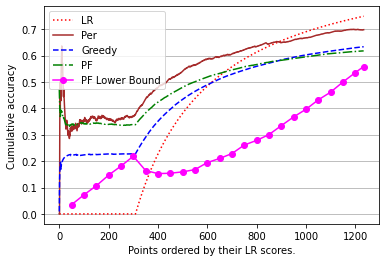

In [8]:
arg_inds = np.argsort(erm_pred)
seqpav_acc = seqpav_pred[arg_inds]
greedy_acc = greedy_pred[arg_inds]
erm_acc = np.zeros(len(erm_pred))
per_acc = np.zeros(len(per_pred))
for i in range(len(erm_pred)):
    erm_acc[i] = erm_pred[arg_inds[i]]
    per_acc[i] = per_pred[arg_inds[i]]

seqpav_plot = np.zeros(len(test_label))
greedy_plot = np.zeros(len(test_label))
erm_plot = np.zeros(len(test_label))
per_plot = np.zeros(len(test_label))
for i in range(len(test_label)):
    seqpav_plot[i] = sum(seqpav_acc[0:i+1])/(i+1)
    greedy_plot[i] = sum(greedy_acc[0:i+1])/(i+1)
    erm_plot[i] = sum(erm_acc[0:i+1])/(i+1)
    per_plot[i] = sum(per_acc[0:i+1])/(i+1)

opt_x = np.array([])
opt_plot = np.array([])
for i in range(len(test_label)):
    if (i > 0 and i % 50 == 0) or i == len(test_label)-1:
        inds = arg_inds[0:i+1]
        data = test_data_scaled[inds]
        label = test_label[inds]
        opt = Mymodel(random_state = 0, solver = 'newton-cg')
        opt.fit(data, label)
        opt_score = opt.score(data, label)
        print(opt_score)
        opt_acc = ((i+1) / test_size) * opt_score * opt_score
        opt_plot = np.append(opt_plot, opt_acc)
        opt_x = np.append(opt_x, i)

        
x = list(range(len(test_label)))
plt.plot(x, erm_plot, color = 'red', linestyle = ':', label = "LR")
plt.plot(x, per_plot, color = 'brown', linestyle = 'solid', label = "Per")
plt.plot(x, greedy_plot, color = 'blue', linestyle = 'dashed', label = "Greedy")
plt.plot(x, seqpav_plot, color = 'green', linestyle = 'dashdot', label = "PF")
plt.plot(opt_x ,opt_plot, color = 'magenta', linestyle = 'solid', marker = 'o', label = "PF Lower Bound")
plt.legend(loc="upper left")
plt.grid(axis = 'y')
plt.ylabel('Cumulative accuracy')
plt.xlabel('Points ordered by their LR scores.')
plt.show()

0.9411764705882353
0.9504950495049505
0.9536423841059603
0.9701492537313433
0.9721115537848606
0.973421926910299
0.9772079772079773
0.8827930174563591
0.7760532150776053
0.7305389221556886
0.7168784029038112
0.6838602329450915
0.6835637480798771
0.6875891583452212
0.6857523302263648
0.6978776529338327
0.6968272620446534
0.7003329633740288
0.704521556256572
0.7182817182817183
0.7202664129400571
0.7284287011807448
0.733275412684622
0.7477102414654455
0.7473684210526316


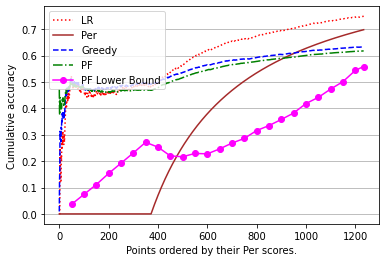

In [9]:


arg_inds = np.argsort(per_pred)
seqpav_acc = seqpav_pred[arg_inds]
greedy_acc = greedy_pred[arg_inds]
erm_acc = np.zeros(len(erm_pred))
per_acc = np.zeros(len(per_pred))
for i in range(len(erm_pred)):
    erm_acc[i] = erm_pred[arg_inds[i]]
    per_acc[i] = per_pred[arg_inds[i]]

seqpav_plot = np.zeros(len(test_label))
greedy_plot = np.zeros(len(test_label))
erm_plot = np.zeros(len(test_label))
per_plot = np.zeros(len(test_label))
for i in range(len(test_label)):
    seqpav_plot[i] = sum(seqpav_acc[0:i+1])/(i+1)
    greedy_plot[i] = sum(greedy_acc[0:i+1])/(i+1)
    erm_plot[i] = sum(erm_acc[0:i+1])/(i+1)
    per_plot[i] = sum(per_acc[0:i+1])/(i+1)

opt_x = np.array([])
opt_plot = np.array([])
for i in range(len(test_label)):
    if (i > 0 and i % 50 == 0) or i == len(test_label)-1:
        inds = arg_inds[0:i+1]
        data = test_data_scaled[inds]
        label = test_label[inds]
        opt = Mymodel(random_state = 0, solver = 'newton-cg')
        opt.fit(data, label)
        opt_score = opt.score(data, label)
        print(opt_score)
        opt_acc = ((i+1) / test_size) * opt_score * opt_score
        opt_plot = np.append(opt_plot, opt_acc)
        opt_x = np.append(opt_x, i)

x = list(range(len(test_label)))
plt.plot(x, erm_plot, color = 'red', linestyle = ':', label = "LR")
plt.plot(x, per_plot, color = 'brown', linestyle = 'solid', label = "Per")
plt.plot(x, greedy_plot, color = 'blue', linestyle = 'dashed', label = "Greedy")
plt.plot(x, seqpav_plot, color = 'green', linestyle = 'dashdot', label = "PF")
plt.plot(opt_x ,opt_plot, color = 'magenta', linestyle = 'solid', marker = 'o', label = "PF Lower Bound")
plt.legend(loc="upper left")
plt.grid(axis = 'y')
plt.ylabel('Cumulative accuracy')
plt.xlabel('Points ordered by their Per scores.')
plt.show()